# Reconstructed particles

In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import uproot

from lcio_checks.util import config, load_or_make

f = uproot.open(f"{config['data_dir']}/P2f_z_eehiq.root")["MyLCTuple"]
rc = f.arrays(filter_name="rc*", entry_stop=-1)
rp = rc[rc.rccid == 101]

## RP Collections in the LCTuple

The reconstructed particles in the LCTuple `rcXXX` namespace are the combination of multiple LCIO collections.
The LCIO collection is tracked in the `rccid` field.

| rccid   | LCIO collection         |
|:--------|:------------------------|
| 101     | PandoraPFOs             |
| 102     | BCALParticles           |
| 103     | PrimaryVertex_RP        |
| 104     | BuildUpVertex_RP        |
| 105     | BuildUpVertex_V0_RP     |

**Note**: If you want to work with _PFO objects I would observe in my detector_, only use `101` and `102`.

Counts in the sample per LCIO collection:

In [2]:
assert {101, 102, 103, 104, 105}.issuperset(np.unique(ak.flatten(rc.rccid)))

for cid, counts in zip(*np.unique(ak.flatten(rc.rccid), return_counts=True)):
    print(f"{cid}:{counts:>7d}")
print(f"\nNumber of events in the sample: {len(rc)}.")

101: 698556
103:  43199
104:    380
105:    145

Number of events in the sample: 43199.


### Vertex collections

For now, we do not plan to study them further.
Let us only mention that all particles in these collection have their type defined as `3`.

In [3]:
assert list(np.unique(ak.flatten(rc[rc.rccid > 102].rctyp).to_numpy())) == [3]

### Particle types in PandoraPFOs

In [4]:
assert 102 not in np.unique(ak.flatten(rc.rccid))

import pandas as pd

uniq, counts = np.unique(
    np.abs(ak.flatten(rc[rc.rccid == 101].rctyp)), return_counts=True
)
df = pd.DataFrame(counts, index=uniq, columns=["counts"])
df.index.name = "Particle species"
df

counts
Particle species        
11                 94921
13                   152
22                292288
211               234886
310                  273
2112               75572
3122                 464

## A closer look into the Pandora PFOs

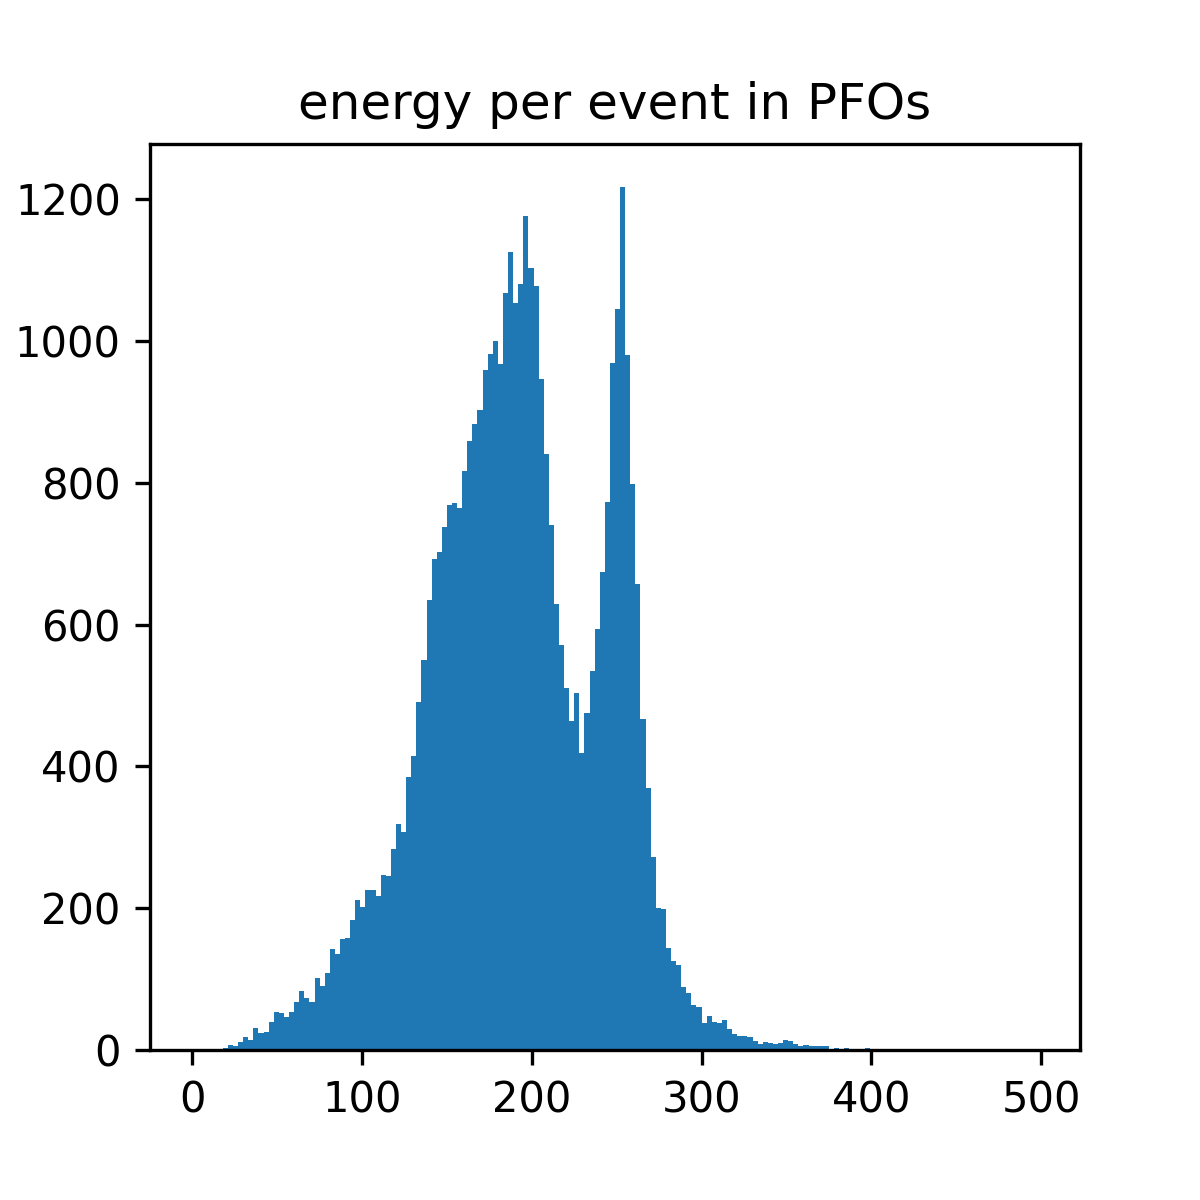

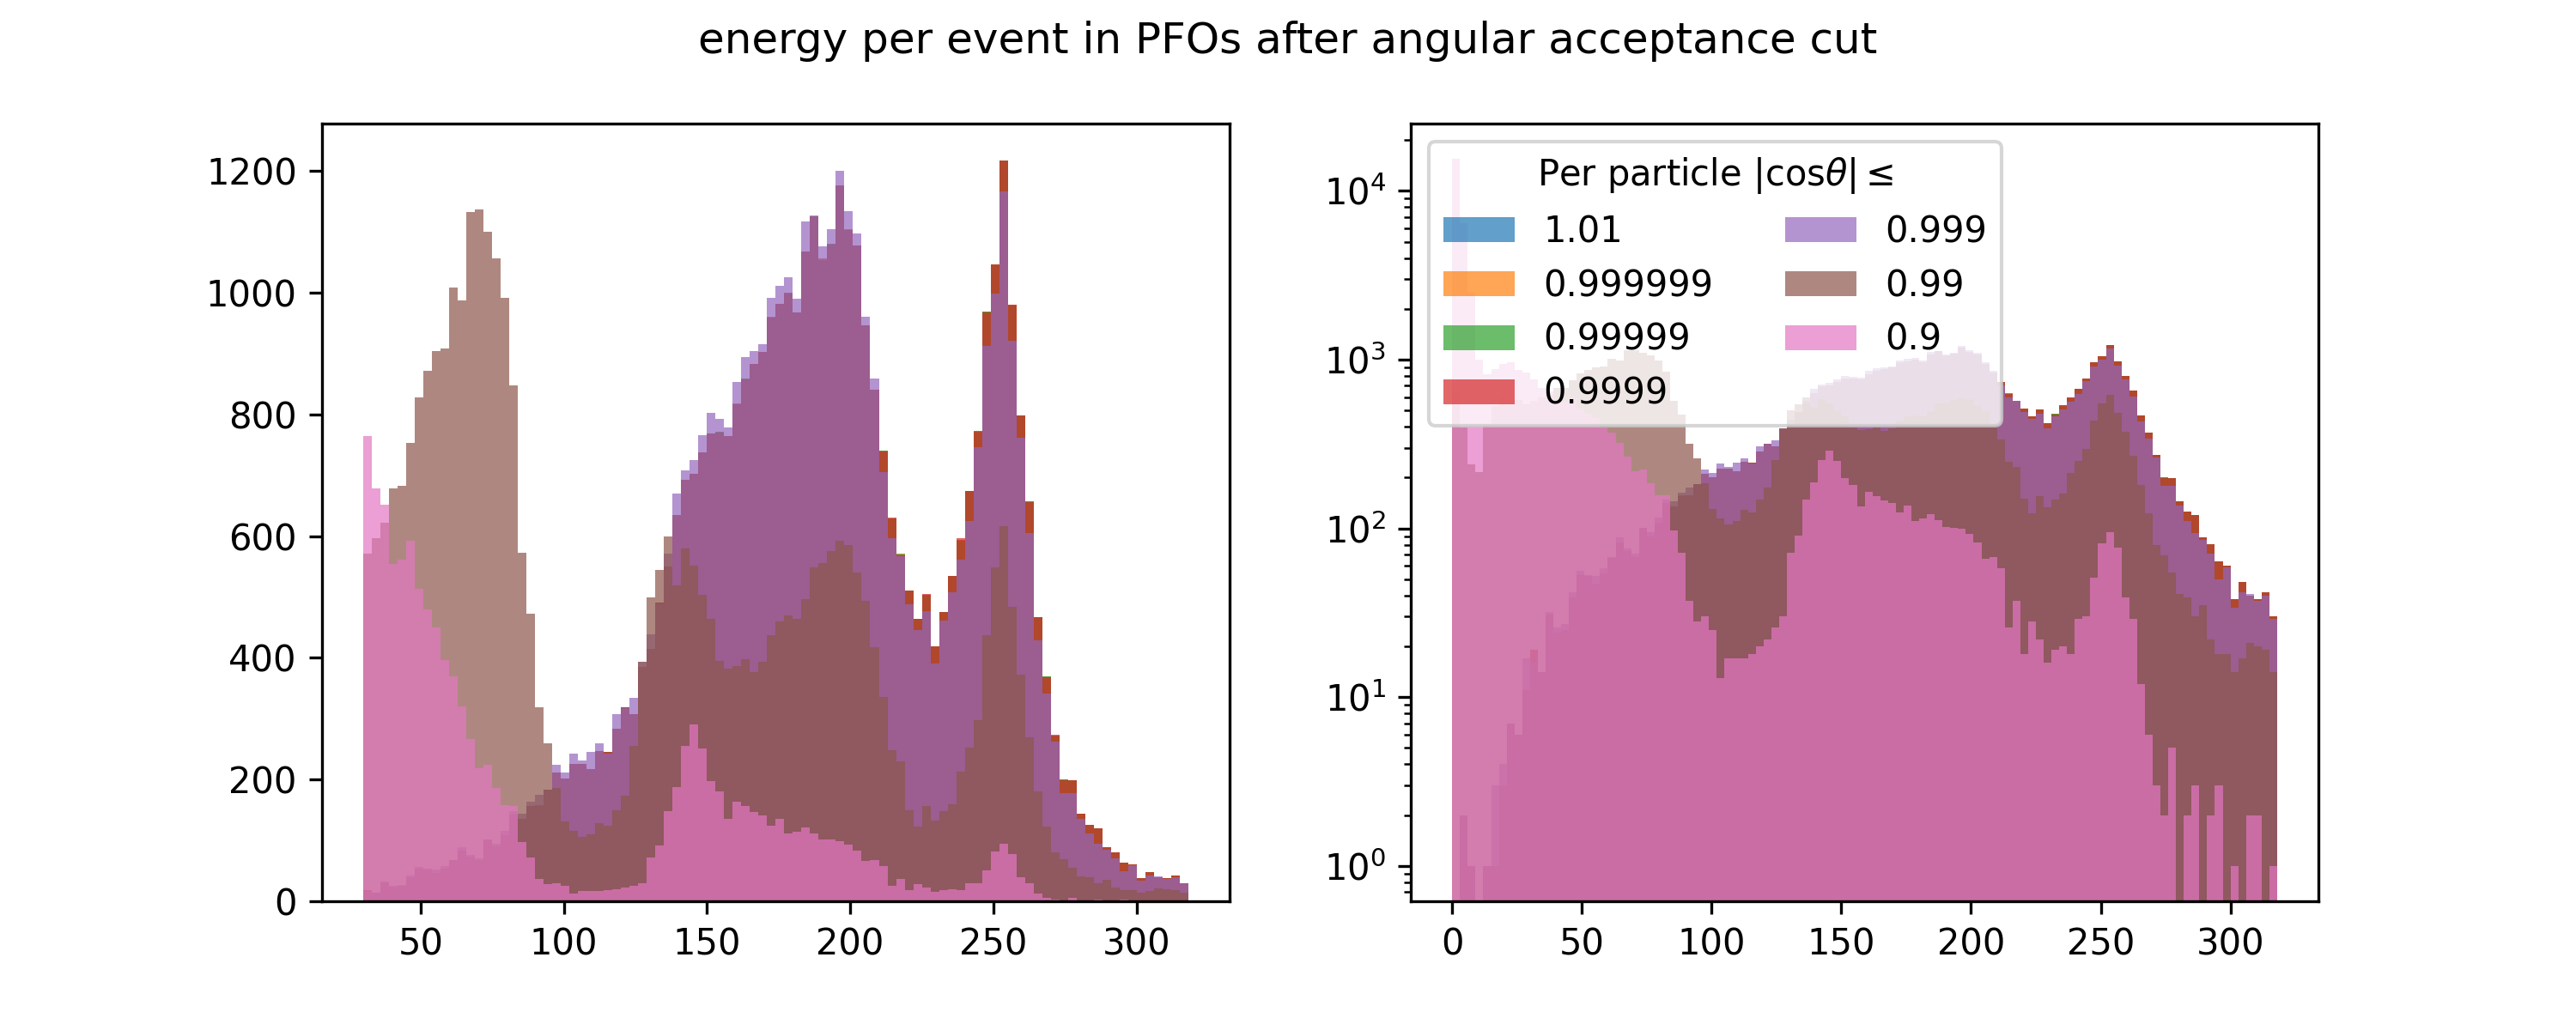

In [5]:
@load_or_make(["pfo_energy_per_event"])
def pfo_energy_per_event():
    bins = np.arange(0, 501, 3)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.hist(ak.sum(rp.rcene, axis=1), bins=bins)
    ax.set_title("energy per event in PFOs")
    return (fig,)


@load_or_make(["pfo_energy_per_event_after_acceptance"])
def pfo_energy_per_event_after_acceptance():
    rcps = rp[rp.rcene != 0]
    bins = np.arange(0, 321, 3)
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    for cos_theta in [1.01, 0.999999, 0.99999, 0.9999, 0.999, 0.99, 0.9]:
        x = ak.sum(rcps[np.abs(rcps.rcmoz) / rcps.rcene < cos_theta].rcene, axis=1)
        axs[0].hist(x, bins=bins[10:], label=str(cos_theta), alpha=0.7)
        axs[1].hist(x, bins=bins, label=str(cos_theta), alpha=0.7)
        axs[1].legend(title="Per particle |cos$\\theta$|$\\leq$", ncol=2)
        axs[1].set_yscale("log")
    fig.suptitle("energy per event in PFOs after angular acceptance cut")
    return (fig,)


pfo_energy_per_event()
pfo_energy_per_event_after_acceptance();

### Angular acceptance

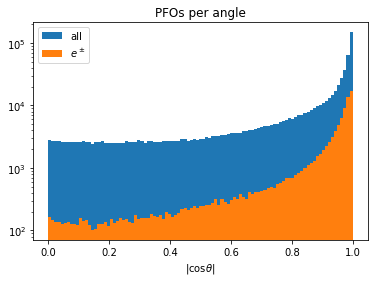

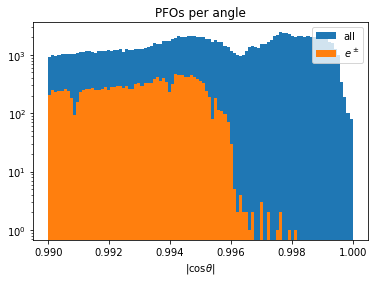

In [6]:
def particles_per_angle(rcps, bins):
    _, ax = plt.subplots(figsize=(6, 4))
    c_theta = np.abs(rcps.rcmoz) / rcps.rcene
    ax.hist(ak.flatten(c_theta), bins=bins, label="all")
    ax.hist(ak.flatten(c_theta[np.abs(rcps.rctyp) == 11]), bins=bins, label=r"$e^\pm$")
    ax.set_title("PFOs per angle")
    ax.set_xlabel("|cos$\\theta$|")
    ax.set_yscale("log")
    ax.legend()
    return ax


particles_per_angle(rp, bins=np.linspace(0, 1, 100))
particles_per_angle(rp, bins=np.linspace(0.99, 1, 100));